In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import wisc_ecephys_tools as wet
import xarray as xr
from ecephys import plot, wne

from findlay2025a import core, dentate_spikes, plotting, ripples, sharp_waves
from findlay2025a.constants import Experiments as Exps

In [11]:
sglx_subject = wet.get_sglx_subject("CNPIX14-Francis")
experiment = Exps.NOD

nb = core.get_project("seahorse")
s3 = core.get_project("shared")

spws = sharp_waves.read_spws(sglx_subject.name, experiment)
rips = ripples.read_ripples(sglx_subject.name, experiment)
dspks = dentate_spikes.read_dspks(sglx_subject.name, experiment)
delta = xr.open_dataarray(
    core.get_cortical_bandpower_file(sglx_subject.name, experiment, "delta")
)
light_dark_periods, light_dark_period_labels = wet.shared.get_light_dark_periods(
    experiment, sglx_subject
)
hg = wne.utils.load_raw_float_hypnogram(
    s3, experiment, sglx_subject.name, simplify=True
)

In [12]:
bslp_start = light_dark_periods[0][0]
bslp_end = light_dark_periods[0][1]
is_nrem_spw = hg.keep_states(["NREM"]).covers_time(delta.time)
is_bsl_spw = (delta.time >= bslp_start) & (delta.time <= bslp_end)
bsl_nrem_delta_mean = delta.sel(time=(is_nrem_spw & is_bsl_spw)).mean()
delta = (delta / bsl_nrem_delta_mean) * 100

In [13]:
is_nrem_spw = hg.keep_states(["NREM"]).covers_time(spws.pk_time)
is_bsl_spw = (spws.pk_time >= bslp_start) & (spws.pk_time <= bslp_end)
bsl_nrem_spws = spws[is_nrem_spw & is_bsl_spw]
bsl_nrem_spw_amp_mean = bsl_nrem_spws["pk_amp"].mean()
spws["pk_amp"] = (spws["pk_amp"] / bsl_nrem_spw_amp_mean) * 100

In [14]:
is_nrem_rip = hg.keep_states(["NREM"]).covers_time(rips.pk_time)
is_bsl_rip = (rips.pk_time >= bslp_start) & (rips.pk_time <= bslp_end)
bsl_nrem_rips = rips[is_nrem_rip & is_bsl_rip]
bsl_nrem_rip_amp_mean = bsl_nrem_rips["pk_amp"].mean()
rips["pk_amp"] = (rips["pk_amp"] / bsl_nrem_rip_amp_mean) * 100

In [15]:
is_nrem_dspk = hg.keep_states(["NREM"]).covers_time(dspks.peak_time)
is_bsl_dspk = (dspks.peak_time >= bslp_start) & (dspks.peak_time <= bslp_end)
bsl_nrem_dspks = dspks[is_nrem_dspk & is_bsl_dspk]
bsl_nrem_dspk_amp_mean = bsl_nrem_dspks["peak_height"].mean()
dspks["peak_height"] = (dspks["peak_height"] / bsl_nrem_dspk_amp_mean) * 100

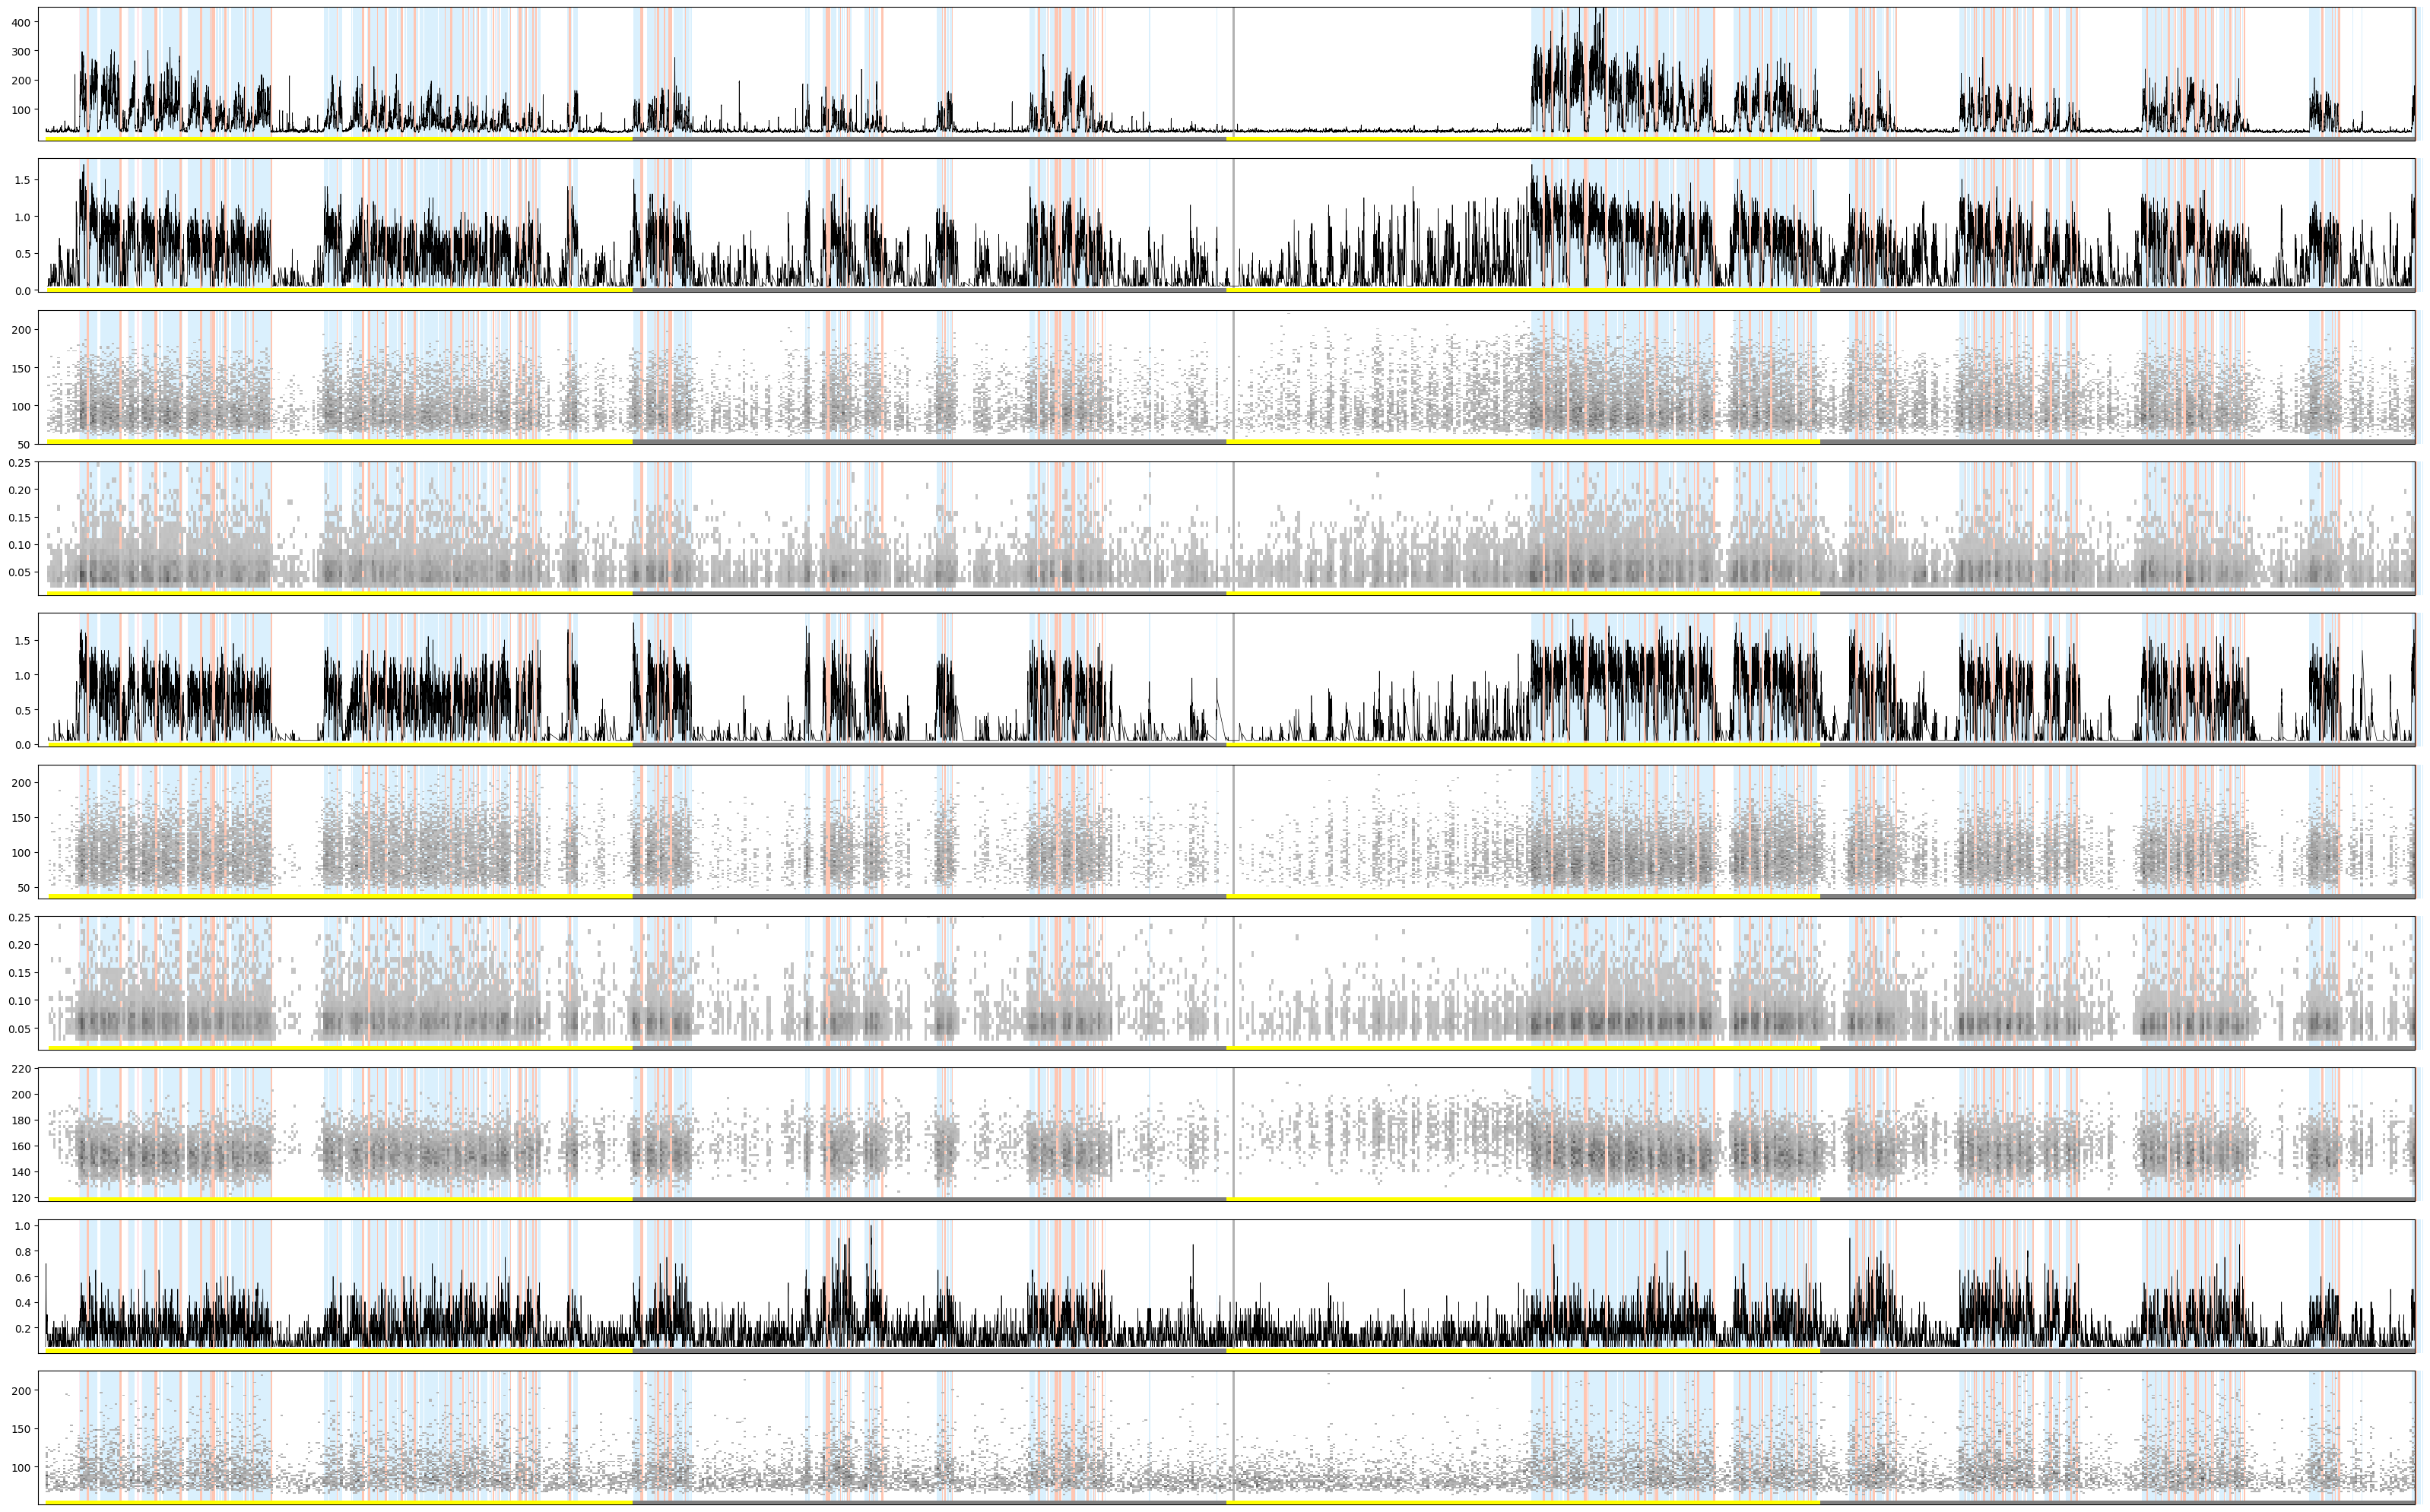

In [ ]:
(
    fig,
    (
        swa_ax,
        spw_rate_ax,
        spw_amp_ax,
        spw_dur_ax,
        rip_rate_ax,
        rip_amp_ax,
        rip_dur_ax,
        rip_freq_ax,
        dspk_rate_ax,
        dspk_amp_ax,
    ),
) = plt.subplots(10, 1, figsize=(32, 20))
plotting.plot_swa_timetrace(delta, swa_ax, smoothing=14)
plotting.plot_event_rate_timetrace(spws, spw_rate_ax)
plotting.plot_event_amplitude_timehist(spws, ax=spw_amp_ax)
plotting.plot_event_duration_timehist(spws, ax=spw_dur_ax)
plotting.plot_event_rate_timetrace(rips, rip_rate_ax)
plotting.plot_event_amplitude_timehist(rips, ax=rip_amp_ax)
plotting.plot_event_duration_timehist(rips, ax=rip_dur_ax)
sns.histplot(rips, x="pk_time", y="freq", ax=rip_freq_ax, binwidth=(180, 2), color="k")
rip_freq_ax.set(xlabel=None, ylabel="Ripple frequency (Hz)", xmargin=0, xticks=[])
plotting.plot_event_rate_timetrace(dspks, dspk_rate_ax, time_col="peak_time")
plotting.plot_event_amplitude_timehist(
    dspks, ax=dspk_amp_ax, time_col="peak_time", amp_col="peak_height"
)
for ax in [
    swa_ax,
    spw_rate_ax,
    spw_amp_ax,
    spw_dur_ax,
    rip_rate_ax,
    rip_amp_ax,
    rip_dur_ax,
    rip_freq_ax,
    dspk_rate_ax,
    dspk_amp_ax,
]:
    plot.plot_hypnogram_overlay(hg, ax=ax, state_colors=plot.publication_colors)
    wet.shared.plot_lights_overlay(
        light_dark_periods, light_dark_period_labels, ax=ax, ymin=0, ymax=0.03
    )
    ax.set_xlim((light_dark_periods[0][0], light_dark_periods[-1][-1]))
    ax.set_ylabel(None)
swa_ax.set_ylim((None, 450))
swa_ax.set_yticks([100, 200, 300, 400])
spw_rate_ax.set_yticks([0, 0.5, 1.0, 1.5])
spw_amp_ax.set_ylim((None, 225))
spw_amp_ax.set_yticks([50, 100, 150, 200])
spw_dur_ax.set_ylim((None, 0.250))
rip_rate_ax.set_yticks([0, 0.5, 1.0, 1.5])
rip_amp_ax.set_ylim((None, 225))
rip_dur_ax.set_ylim((None, 0.250))
dspk_amp_ax.set_ylim((None, 225))
plt.tight_layout()

# fig.savefig(nb.get_project_file('figures/nod_supplemental.png'), dpi=600, bbox_inches='tight')